<a href="https://colab.research.google.com/github/heejeongJ/DL_pt/blob/Autoencoder-%234/Autoencoder_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9912422/9912422 [00:00<00:00, 123245720.18it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 123607850.84it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33199518.98it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20572925.24it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



cuda:0
Epoch [0/10], Loss: 2.5534
Epoch [0/10], Loss: 2.3163
Epoch [0/10], Loss: 2.1333
Epoch [0/10], Loss: 1.9758
Epoch [0/10], Loss: 1.8432
Epoch [0/10], Loss: 1.7427
Epoch [0/10], Loss: 1.6142
Epoch [0/10], Loss: 1.5298
Epoch [0/10], Loss: 1.4350
Epoch [0/10], Loss: 1.3632
Epoch [0/10], Loss: 1.2863
Epoch [0/10], Loss: 1.2224
Epoch [0/10], Loss: 1.1467
Epoch [0/10], Loss: 1.0822
Epoch [0/10], Loss: 1.0244
Epoch [0/10], Loss: 0.9748
Epoch [0/10], Loss: 0.9124
Epoch [0/10], Loss: 0.8631
Epoch [0/10], Loss: 0.8189
Epoch [0/10], Loss: 0.7690
Epoch [0/10], Loss: 0.7288
Epoch [0/10], Loss: 0.6944
Epoch [0/10], Loss: 0.6581
Epoch [0/10], Loss: 0.6238
Epoch [0/10], Loss: 0.5940
Epoch [0/10], Loss: 0.5643
Epoch [0/10], Loss: 0.5355
Epoch [0/10], Loss: 0.5044
Epoch [0/10], Loss: 0.4951
Epoch [0/10], Loss: 0.4620
Epoch [0/10], Loss: 0.4462
Epoch [0/10], Loss: 0.4226
Epoch [0/10], Loss: 0.4025
Epoch [0/10], Loss: 0.3904
Epoch [0/10], Loss: 0.3661
Epoch [0/10], Loss: 0.3605
Epoch [0/10], Loss: 0

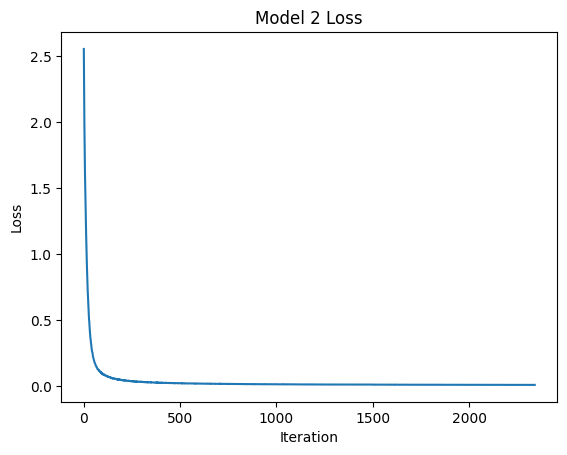

tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)


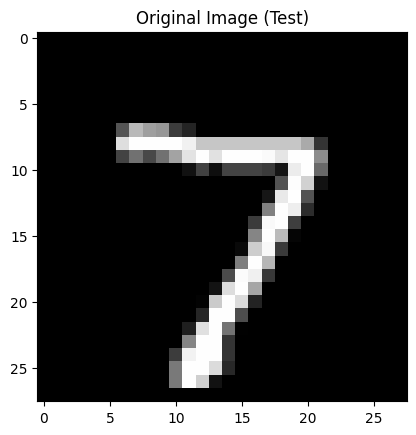

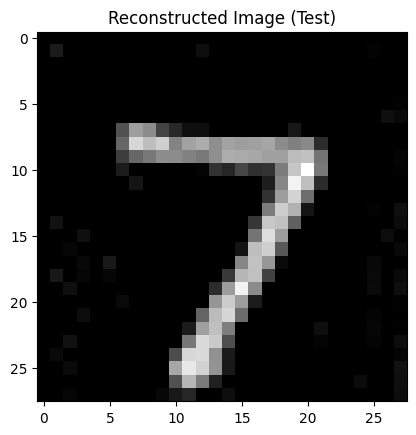

torch.Size([256, 28, 28])


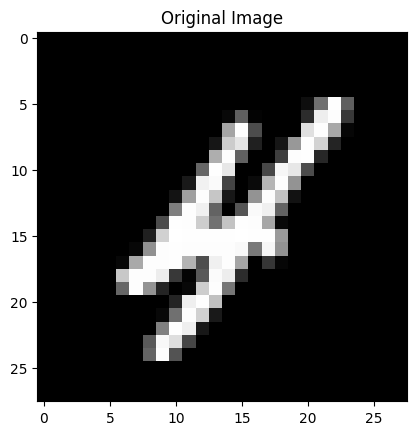

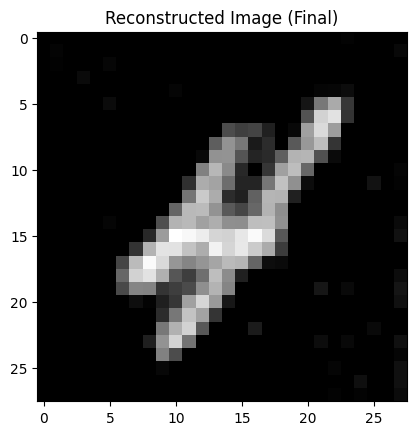

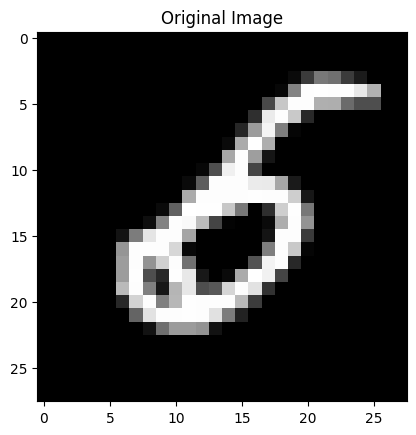

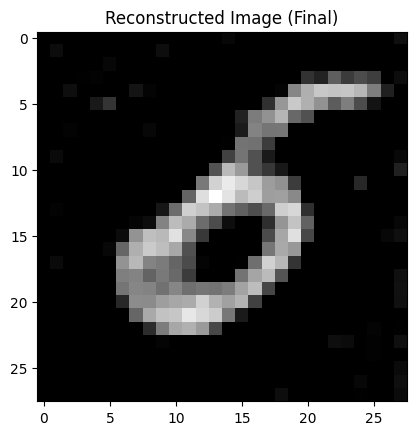

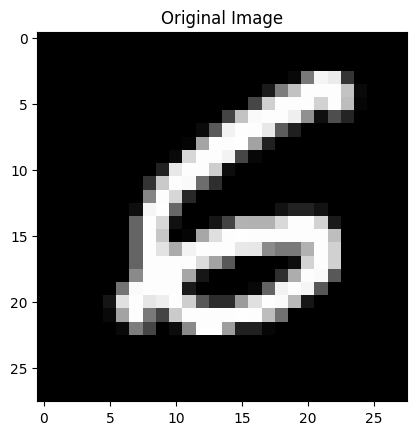

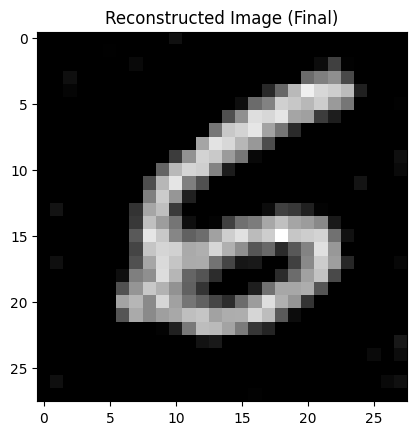

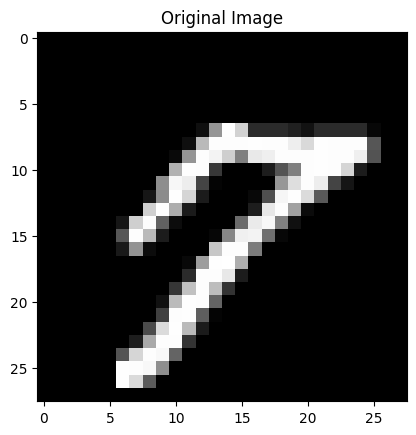

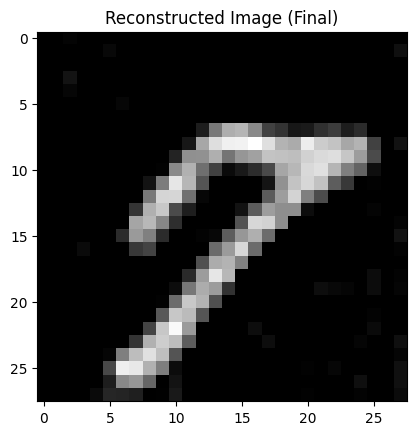

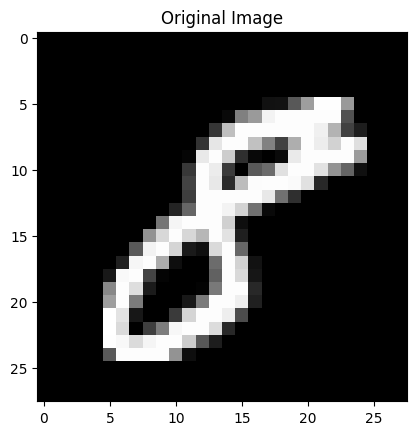

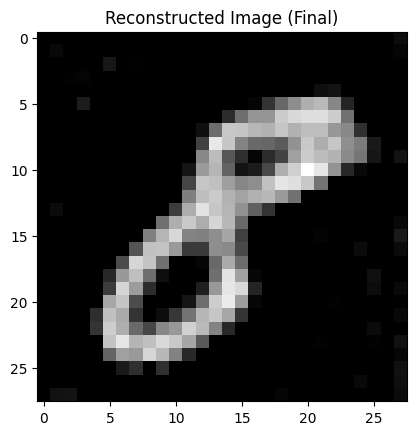

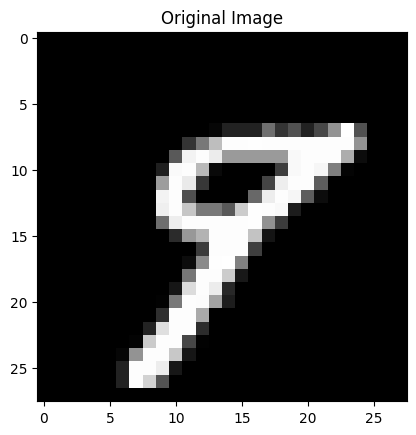

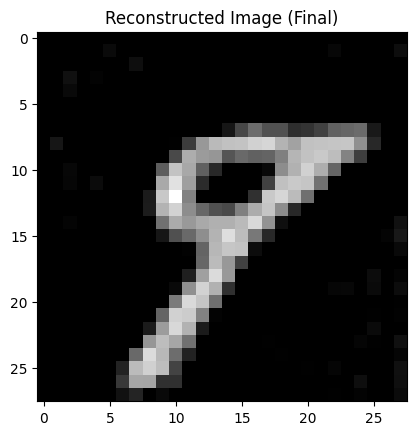

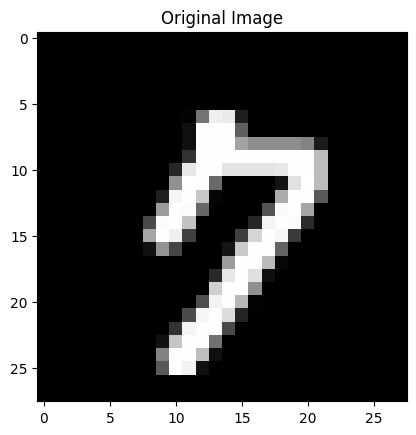

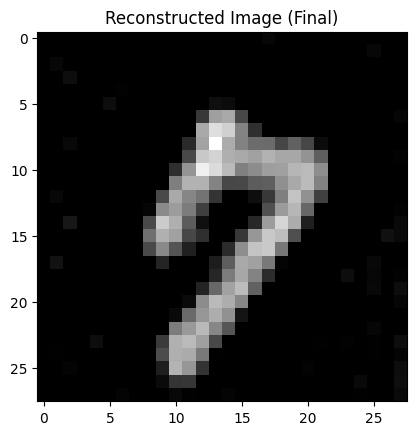

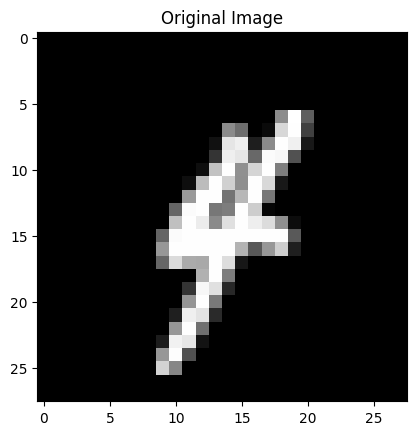

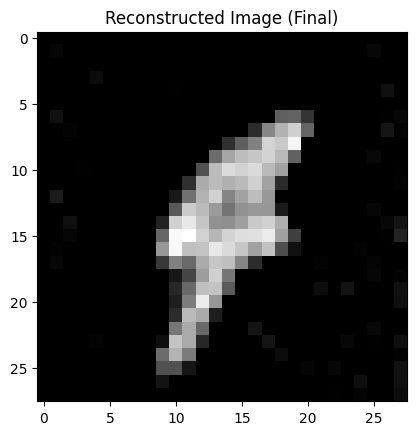

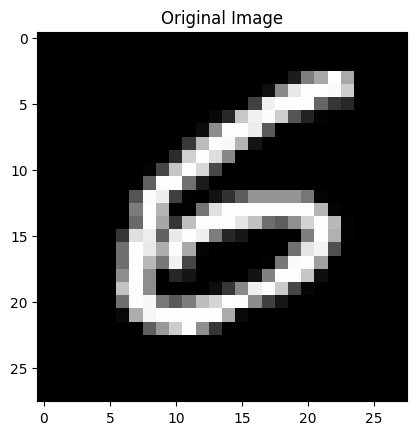

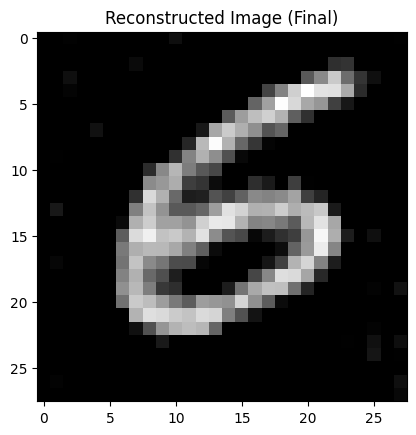

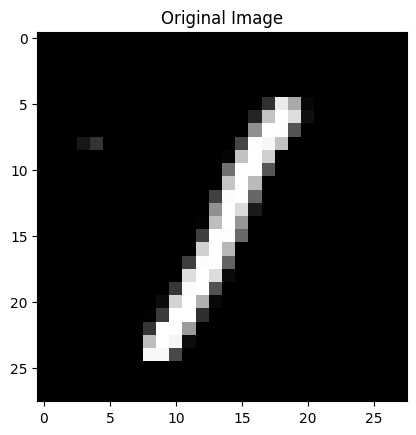

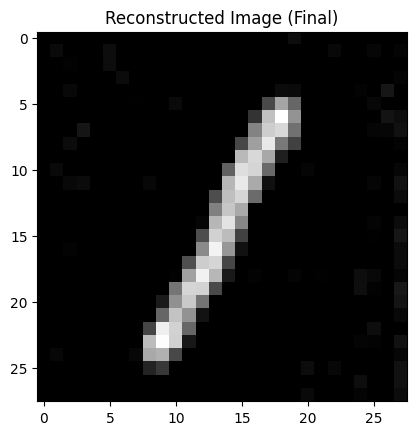

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 하이퍼 파라미터 지정
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 데이터 다운로드
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# DataLoader 설정
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# [합성곱] 모델 선언 - Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(batch_size, -1)
        return out

# [합성곱] 모델 선언 - Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, 1, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        out = x.view(x.size(0), 64, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

# [합성곱] 손실 함수, 최적화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

# [합성곱] 학습
noise_std = 0.1  # 노이즈 레벨 조정
losses = []

for epoch in range(num_epoch):
    for i, [image, _] in enumerate(train_loader):
        optimizer.zero_grad()

        # 입력 이미지에 랜덤 가우시안 노이즈 추가
        noisy_images = image + noise_std * torch.randn_like(image)
        noisy_images = torch.clamp(noisy_images, 0, 1)  # 픽셀 값이 [0, 1] 범위에 있도록 보장

        noisy_images = noisy_images.to(device)  # GPU로 옮기기
        output = encoder(noisy_images)
        output = decoder(output)

        loss = loss_func(output, noisy_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f'Epoch [{epoch}/{num_epoch}], Loss: {loss.item():.4f}')

# Loss 그래프 출력
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Model 2 Loss')
plt.show()

# 훈련 영상을 통한 확인
with torch.no_grad():
    for i, [image, _] in enumerate(test_loader):
        x = image.to(device)

        optimizer.zero_grad()
        encoded = encoder(x)
        decoded = decoder(encoded)

        # 테스트 중간 결과 확인
        if i % 1000 == 0:
            print(loss)

            plt.imshow(torch.squeeze(x[0]).cpu().numpy(), cmap='gray')
            plt.title('Original Image (Test)')
            plt.show()

            plt.imshow(torch.squeeze(decoded[0]).cpu().numpy(), cmap='gray')
            plt.title('Reconstructed Image (Test)')
            plt.show()

# 최종 결과 확인
out_img = torch.squeeze(decoded.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(x[i]).cpu().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.show()

    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.title('Reconstructed Image (Final)')
    plt.show()
